## Transformer로 번역기 만들기

### 데이터 
한국어, 영어 번역은 아래의 링크에서 다운받아 사용하였다.      
https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1

### 필요한 모듈 가져오기

In [65]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

%config InlineBackend.figure_format = 'retina'
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

In [66]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import re
import os
import io
import time
import random

import seaborn # Attention 시각화를 위해 필요!

print(tf.__version__)

2.4.1


### Step 1. 데이터 정제 및 토큰화 
1.  set 데이터형이 중복을 허용하지 않으므로, 이를 이용해 중복 데이터 제거. 
2. 

In [67]:
data_dir = os.getenv('HOME')+'/aiffel/transformer/data'
kor_path = data_dir+"/korean-english-park.train.ko"
eng_path = data_dir+"/korean-english-park.train.en"

# 데이터 정제 및 토큰화
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: 
        kor = f.read().splitlines()
    with open(eng_path, "r") as f: 
        eng = f.read().splitlines()
    assert len(kor) == len(eng)

    raw = zip(kor, eng)
    cleaned_corpus = set(raw)
    
    return cleaned_corpus

cleaned_corpus = clean_corpus(kor_path, eng_path) 

In [68]:
print(len(cleaned_corpus))

78968


다음과 같은 전처리를 해준다. 
* 모든 입력을 소문자로 변환합니다.
* 알파벳, 문장부호, 한글만 남기고 모두 제거합니다.
* 문장부호 양옆에 공백을 추가합니다.
* 문장 앞뒤의 불필요한 공백을 제거합니다.

In [69]:
def preprocess_sentence(sentence): 
    
    sentence = sentence.lower() # 소문자로 변환 
    sentence = re.sub(r"[^a-zA-Z.,?!가-힣ㄱ-하-ㅣ]+", " ", sentence) # 알파벳, 문장부호, 한글 남기고 제거 
    sentence = re.sub(r"([?!.,])", r" \1 ", sentence) 
    
    sentence = sentence.strip() # 문자열 앞 뒤 공백 제거 
    
    return sentence 

한글 말뭉치 kor_corpus 와 영문 말뭉치 eng_corpus 를 각각 분리한 후, 정제하여 토큰화를 진행합니다! 토큰화에는 Sentencepiece를 활용하세요. 첨부된 공식 사이트를 참고해 아래 조건을 만족하는 generate_tokenizer() 함수를 정의합니다. 최종적으로 ko_tokenizer 과 en_tokenizer 를 얻으세요. en_tokenizer에는 set_encode_extra_options("bos:eos") 함수를 실행해 타겟 입력이 문장의 시작 토큰과 끝 토큰을 포함할 수 있게 합니다.    
* 단어 사전을 매개변수로 받아 원하는 크기의 사전을 정의할 수 있게 합니다. (기본: 20,000)
* 학습 후 저장된 model 파일을 SentencePieceProcessor() 클래스에 Load()한 후 반환합니다.
* 특수 토큰의 인덱스를 아래와 동일하게 지정합니다.
\<PAD> : 0 / \<BOS> : 1 / \<EOS> : 2 / \<UNK> : 3

In [70]:
kor_corpus, eng_corpus = zip(*cleaned_corpus)
print(len(kor_corpus))
print(len(eng_corpus))

78968
78968


In [71]:
kor_corpus[1:3]

('아버 유엔 인권고등판무관은 “목격자들은 유괴, 성폭행, 인권 위반 행위를 서슴없이 저지른 자들이 아직 까지도 이 같은 행동을 하고 다닌다”고 말했다.',
 'Opera Star Pavarotti is in critical condition˝오페라 스타 파바로티, 위독한 상태˝2007.12 원문 & 독해설명 인쇄')

In [72]:
ko_corpus = []
   
for sentence in kor_corpus: 
    sentence = preprocess_sentence(sentence)
    ko_corpus.append(sentence)

In [73]:
en_corpus = []
   
for sentence in eng_corpus: 
    sentence = preprocess_sentence(sentence)
    en_corpus.append(sentence)

In [74]:
ko_corpus[:3]

['우리는 그들의 요구를 들어줄만한 시설이 갖추어져 있지 않았어요 .',
 '아버 유엔 인권고등판무관은 목격자들은 유괴 ,  성폭행 ,  인권 위반 행위를 서슴없이 저지른 자들이 아직 까지도 이 같은 행동을 하고 다닌다 고 말했다 .',
 'opera star pavarotti is in critical condition 오페라 스타 파바로티 ,  위독한 상태  .  원문 독해설명 인쇄']

In [75]:
import sentencepiece as spm 

In [76]:
with open('kor_sp.txt', 'w') as f:
    f.write('\n'.join(ko_corpus))

In [77]:
with open('kor_sp.txt', 'r') as kf:
    print(kf.readline())

우리는 그들의 요구를 들어줄만한 시설이 갖추어져 있지 않았어요 .



In [78]:
with open('eng_sp.txt', 'w') as f:
    f.write('\n'.join(en_corpus))

In [79]:
with open('eng_sp.txt', 'r') as kf:
    print(kf.readline())

we weren t equipped to meet their needs .



In [80]:
# spm 학습

kor_path = os.getenv("HOME") + '/aiffel/NLP/kor_sp.txt'
eng_path = os.getenv("HOME") + '/aiffel/NLP/eng_sp.txt'

vocab_size = 20000

spm.SentencePieceTrainer.Train('--input={} --pad_id=0 --bos_id=1 --eos_id=2 --unk_id=3 \
                             --model_prefix=kor --vocab_size={} '.format(kor_path, vocab_size)) 
        
spm.SentencePieceTrainer.Train('--input={} --pad_id=0 --bos_id=1 --eos_id=2 --unk_id=3 \
                               --model_prefix=eng --vocab_size={} '.format(eng_path, vocab_size))    

In [81]:
import pandas as pd

vocab_list = pd.read_csv('kor.vocab', sep='\t')
vocab_list[:8]

,<pad>,0
0,<s>,0.00000
1,</s>,0.00000
2,<unk>,0.00000
3,▁,-3.21458
4,▁.,-3.24837
5,을,-3.61098
6,는,-3.75601
7,의,-3.77927


In [82]:
from tqdm import tqdm_notebook    # Process 과정을 보기 위해

In [83]:
src_corpus = []

assert len(ko_corpus) == len(en_corpus)

k = spm.SentencePieceProcessor()
k.Load('kor.model')

# 토큰의 길이가 50 이하인 문장만 남깁니다. 
for idx in tqdm_notebook(range(len(ko_corpus))):
    tensor = k.EncodeAsIds(ko_corpus[idx])
    if len(tensor) <= 50:
        src_corpus.append(tensor)
   
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/78968 [00:00<?, ?it/s]

In [84]:
tgt_corpus = []

assert len(ko_corpus) == len(en_corpus)

e = spm.SentencePieceProcessor()
e.Load('eng.model')
e.set_encode_extra_options("bos:eos") 

# 토큰의 길이가 50 이하인 문장만 남깁니다. 
for idx in tqdm_notebook(range(len(en_corpus))):
    tensor = e.EncodeAsIds(en_corpus[idx])
    if len(tensor) <= 50:
        tgt_corpus.append(tensor)
   
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


  0%|          | 0/78968 [00:00<?, ?it/s]

In [85]:
#with open("kor.vocab", 'r') as f:
#    vocab = f.readlines()
    
#word_index = {}
#index_word = {}

#for idx, line in enumerate(vocab):
#    word = line.split("\t")[0]
#    word_index.update({idx: word})
#    index_word.update({word:idx})

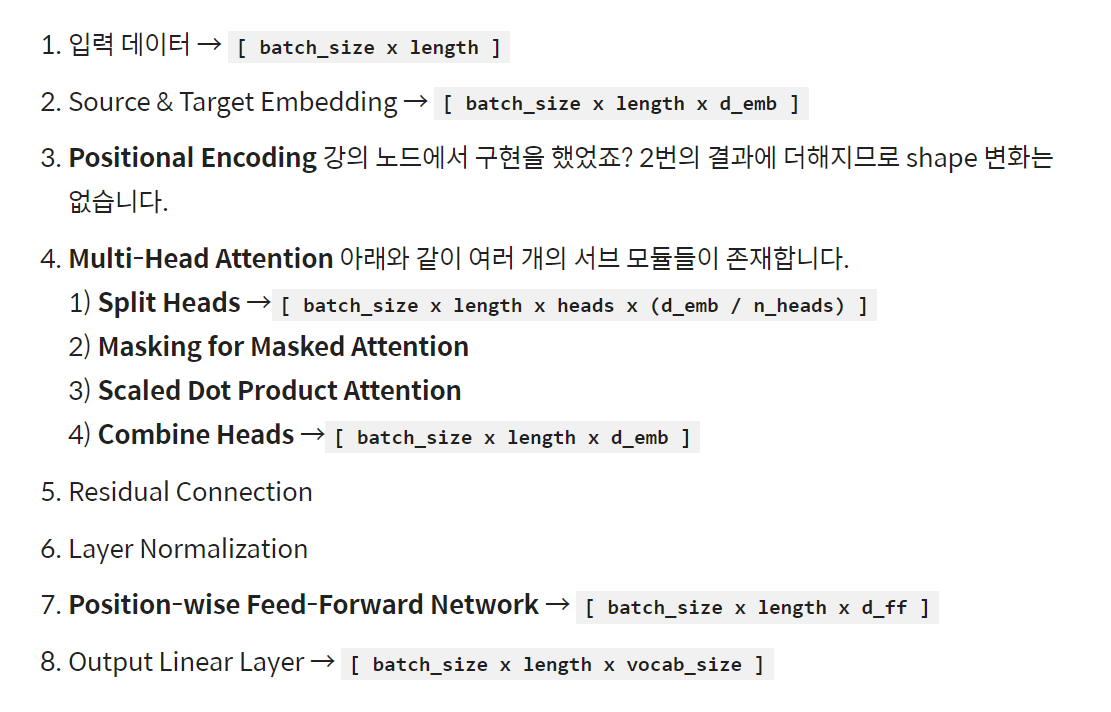

### Positional Encoding
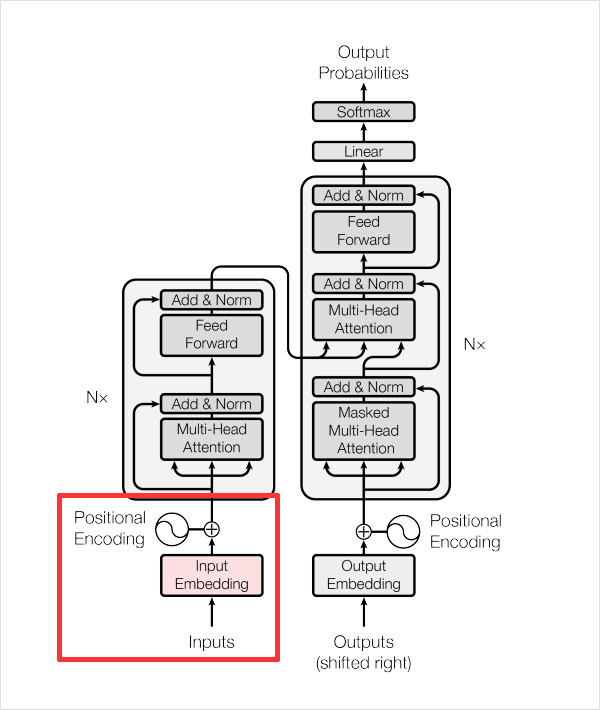

In [86]:
def positional_encoding(pos, d_model):
    
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    
    return sinusoid_table


### Multi-head Attention
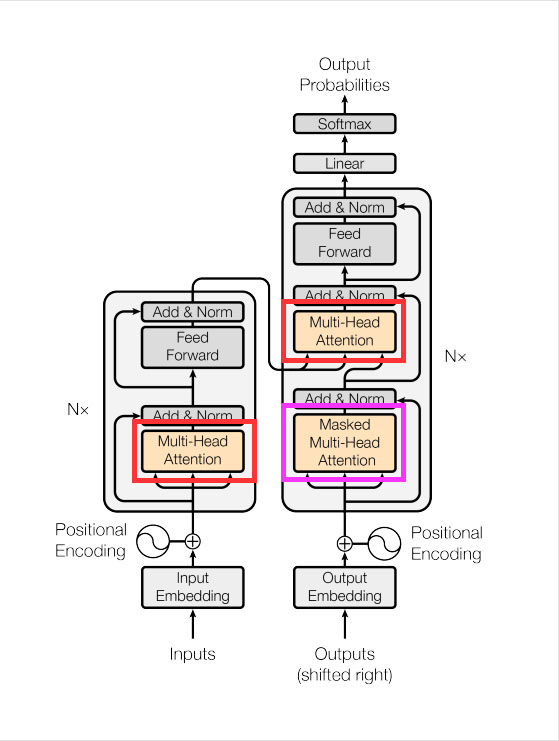

* Q, K, V Linear: tf Dense implements the operation: output = activation(dot(input, kernel) + bias) where activation is the element-wise activation function passed as the activation argument, kernel is a weights matrix created by the layer, and bias is a bias vector created by the layer (only applicable if use_bias is True). If no activiation is applied (specified), a linear activation is applied e.g., a(x) = x. 
* 

In [87]:
class MultiHeadAttention(tf.keras.layers.Layer):
    
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model) # Linear Layer
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        
        QK_t = tf.matmul(Q, K, transpose_b=True) # Q와 K transpose 곱 
        scaled_qk_t = QK_t / tf.math.sqrt(d_k) #d_k sqrt로 나눠줘서 scaling해줌 
        
        if mask is not None: scaled_qk_t +=(mask*-1e9)


        attentions = tf.nn.softmax(scaled_qk_t, axis=-1) # Attention Weights 값 구하기
        out = tf.matmul(attentions, V) # Attention 값을 V에 곱하기 

        return out, attentions
        

    def split_heads(self, x):
        
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth)) # x: [ batch x length x emb ]
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3]) # return:[ batch x length x heads x self.depth ]

        return split_x

    def combine_heads(self, x):
        
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))

        return combined_x
    

    def call(self, Q, K, V, mask):
        """
        아래 순서에 따라 소스를 작성하세요.

        Step 1: Linear_in(Q, K, V) -> WQ, WK, WV
        Step 2: Split Heads(WQ, WK, WV) -> WQ_split, WK_split, WV_split
        Step 3: Scaled Dot Product Attention(WQ_split, WK_split, WV_split)
                 -> out, attention_weights
        Step 4: Combine Heads(out) -> out
        Step 5: Linear_out(out) -> out

        """

        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
        
        out, attention_weights = self.scaled_dot_product_attention(WQ_splits, WK_splits, WV_splits, mask)
        
        out = self.combine_heads(out)
        out = self.linear(out)
        
        return out, attention_weights



### Position-wise Feed-Forward Network 
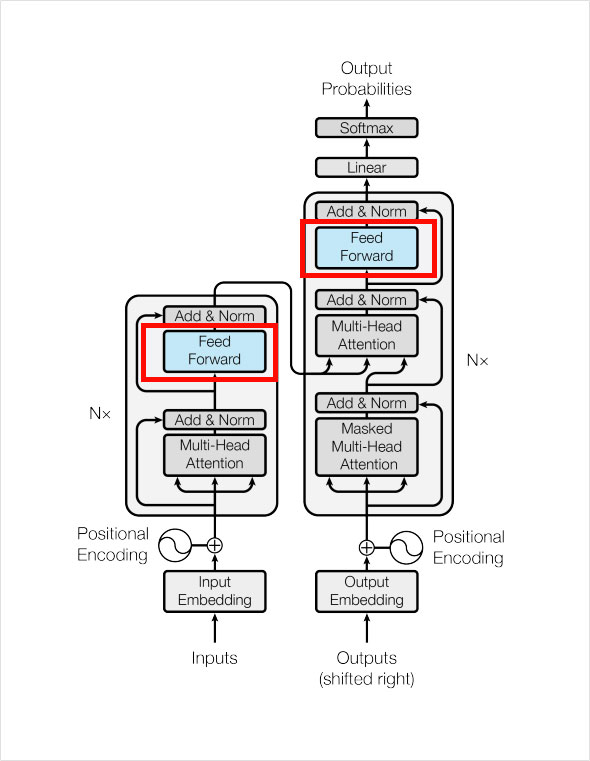

* d_ff 는 논문의 설명대로라면 2048 일 거고, d_model 은 512
* batch x length x d_model  의 입력을 받아 w_1 이 2048차원으로 매핑하고 활성함수 ReLU를 적용한 후, 다시 w_2 를 통해 512차원으로 되돌리는 과정

In [88]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out


### 모듈 조립

In [89]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn


In [90]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [91]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns


In [92]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns


In [93]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared=True,
                    ):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: 
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: 
            out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

### Masking
* generate_padding_mask() 는 Attention을 할 때에 \<PAD> 토큰에도 Attention을 주는 것을 방지해 주는 역할을 한다. Sequence-to-Sequence 모델에서 Loss에 대한 Masking을 해줄 때도 위와 같은 방법으로 진행했었다. 한 배치의 데이터에서 \<PAD> 토큰으로 이뤄진 부분을 모두 찾아내는 마스크를 생성한다. 

In [94]:
import numpy as np
import tensorflow as tf

def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask


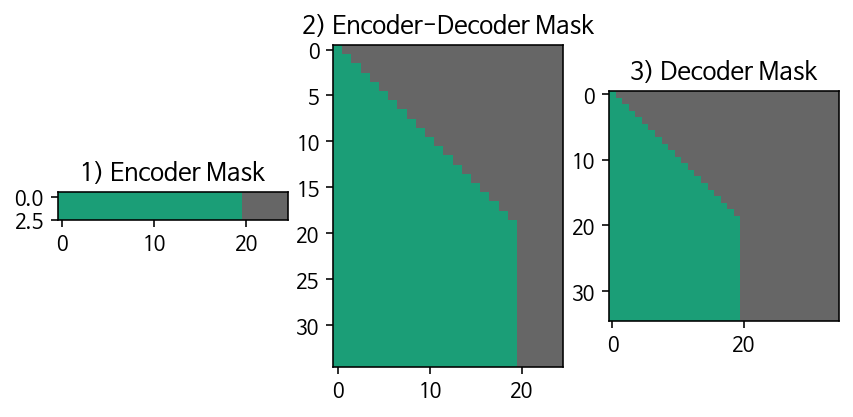

In [95]:
import matplotlib.pyplot as plt

batch, length = 16, 20
src_padding = 5
tgt_padding = 15

src_pad = tf.zeros(shape=(batch, src_padding))
tgt_pad = tf.zeros(shape=(batch, tgt_padding))

sample_data = tf.ones(shape=(batch, length))

sample_src = tf.concat([sample_data, src_pad], axis=-1)
sample_tgt = tf.concat([sample_data, tgt_pad], axis=-1)

enc_mask, dec_enc_mask, dec_mask = \
generate_masks(sample_src, sample_tgt)

fig = plt.figure(figsize=(7, 7))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title('1) Encoder Mask')
ax2.set_title('2) Encoder-Decoder Mask')
ax3.set_title('3) Decoder Mask')

ax1.imshow(enc_mask[:3, 0, 0].numpy(), cmap='Dark2')
ax2.imshow(dec_enc_mask[0, 0].numpy(), cmap='Dark2')
ax3.imshow(dec_mask[0, 0].numpy(), cmap='Dark2')

plt.show()

### Learning Rate 

In [96]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

learning_rate = LearningRateScheduler(512)

optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)


In [97]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [98]:
# Train Step 함수 정의

@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    # [[YOUR CODE]]
    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns

In [99]:
transformer = Transformer(n_layers=2, 
                         d_model=512,
                         n_heads=8,
                         d_ff=2048,
                         src_vocab_size=len(enc_train),
                         tgt_vocab_size=len(dec_train),
                         pos_len=200,
                         dropout=0.3,
                         )

In [100]:
# Attention 시각화 함수

def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [101]:
# 번역 생성 함수

def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [102]:
# 번역 생성 및 Attention 시각화 결합

def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

In [103]:
enc_train.shape

(76670, 50)

In [107]:
idx_list = list(range(0, enc_train.shape[0], 64))
idx_list

[0,
 64,
 128,
 192,
 256,
 320,
 384,
 448,
 512,
 576,
 640,
 704,
 768,
 832,
 896,
 960,
 1024,
 1088,
 1152,
 1216,
 1280,
 1344,
 1408,
 1472,
 1536,
 1600,
 1664,
 1728,
 1792,
 1856,
 1920,
 1984,
 2048,
 2112,
 2176,
 2240,
 2304,
 2368,
 2432,
 2496,
 2560,
 2624,
 2688,
 2752,
 2816,
 2880,
 2944,
 3008,
 3072,
 3136,
 3200,
 3264,
 3328,
 3392,
 3456,
 3520,
 3584,
 3648,
 3712,
 3776,
 3840,
 3904,
 3968,
 4032,
 4096,
 4160,
 4224,
 4288,
 4352,
 4416,
 4480,
 4544,
 4608,
 4672,
 4736,
 4800,
 4864,
 4928,
 4992,
 5056,
 5120,
 5184,
 5248,
 5312,
 5376,
 5440,
 5504,
 5568,
 5632,
 5696,
 5760,
 5824,
 5888,
 5952,
 6016,
 6080,
 6144,
 6208,
 6272,
 6336,
 6400,
 6464,
 6528,
 6592,
 6656,
 6720,
 6784,
 6848,
 6912,
 6976,
 7040,
 7104,
 7168,
 7232,
 7296,
 7360,
 7424,
 7488,
 7552,
 7616,
 7680,
 7744,
 7808,
 7872,
 7936,
 8000,
 8064,
 8128,
 8192,
 8256,
 8320,
 8384,
 8448,
 8512,
 8576,
 8640,
 8704,
 8768,
 8832,
 8896,
 8960,
 9024,
 9088,
 9152,
 9216,
 928

In [104]:
from tqdm.notebook import tqdm 

BATCH_SIZE = 64
EPOCHS = 5

examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다."
]

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    for example in examples:
        translate(example, transformer, k, e)

  0%|          | 0/1198 [00:00<?, ?it/s]

ValueError: in user code:

    <ipython-input-98-c11de7ea8dd1>:11 train_step  *
        predictions, enc_attns, dec_attns, dec_enc_attns =         model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
    <ipython-input-93-38d573538b61>:51 call  *
        dec_out, dec_attns, dec_enc_attns =         self.decoder(dec_in, enc_out, causality_mask, dec_mask)
    <ipython-input-30-0ef3ee6d2dd9>:20 call  *
        out, dec_attn, dec_enc_attn =             self.dec_layers[i](out, enc_out, causality_mask, padding_mask)
    <ipython-input-39-611f0babcfc6>:32 call  *
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
    <ipython-input-25-b1a577c52750>:69 call  *
        out, attention_weights = self.scaled_dot_product_attention(WQ_splits, WK_splits, WV_splits, mask)
    <ipython-input-25-b1a577c52750>:19 scaled_dot_product_attention  *
        QK_t = tf.matmul(Q, K, transpose_b=True) # Q와 K transpose 곱
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper  **
        return target(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:3277 matmul
        a, b, adj_x=adjoint_a, adj_y=adjoint_b, name=name)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/gen_math_ops.py:1535 batch_mat_mul_v2
        "BatchMatMulV2", x=x, y=y, adj_x=adj_x, adj_y=adj_y, name=name)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py:750 _apply_op_helper
        attrs=attr_protos, op_def=op_def)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/func_graph.py:592 _create_op_internal
        compute_device)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:3536 _create_op_internal
        op_def=op_def)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:2016 __init__
        control_input_ops, op_def)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:1856 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimensions must be equal, but are 0 and 64 for '{{node transformer_2/decoder_2/decoder_layer_4/multi_head_attention_15/MatMul}} = BatchMatMulV2[T=DT_FLOAT, adj_x=false, adj_y=true](transformer_2/decoder_2/decoder_layer_4/multi_head_attention_15/transpose, transformer_2/decoder_2/decoder_layer_4/multi_head_attention_15/transpose_1)' with input shapes: [0,8,?,64], [64,8,50,64].
